<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task" data-toc-modified-id="Task-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Solution" data-toc-modified-id="Solution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Solution</a></span><ul class="toc-item"><li><span><a href="#Decision-Tree-Implementation" data-toc-modified-id="Decision-Tree-Implementation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Decision Tree Implementation</a></span></li><li><span><a href="#Decision-Tree-Feature-Importance" data-toc-modified-id="Decision-Tree-Feature-Importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Decision Tree Feature Importance</a></span></li><li><span><a href="#Forest-implementation" data-toc-modified-id="Forest-implementation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Forest implementation</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Tree-number-influence" data-toc-modified-id="Tree-number-influence-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Tree number influence</a></span></li></ul></li><li><span><a href="#Results-and-discussion" data-toc-modified-id="Results-and-discussion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results and discussion</a></span></li></ul></div>

# Task

Implement a decision tree (classification tree to be precise) using Python (incl. Numpy etc.)
and use it on the SPAM-Dataset. Use a metric of your choice as a loss function.

1. Assume that classifying a genuine E-Mail as spam is ten times worse than classifying
spam as genuine. How would you change the design of your decision tree?
2. Use your tree to analyze feature importance. Plot the difference between the top 5 features (check spambase.names to check what features those belong to).


Implement a Random Forest and use it on the SPAM-Dataset.
1. Print a confusion matrix (you can use package implementations here).
2.What is a good number of trees in the forest?

# Setup

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

Tree = namedtuple('Tree', 'features model')

In [2]:
def generate_csv():
    with open('data/spambase.cutnames') as h_reader, open(
        'data/spambase.data') as d_reader, open(
        'data/spambase.csv', 'w') as writer:
    
        headers = [line.split(':')[0] for line in h_reader] + ['spam']
        writer.write(','.join(headers) + '\n')
        writer.writelines(d_reader.readlines())

# generate_csv()

In [3]:
df = pd.read_csv('data/spambase.csv')
y = df['spam'].copy()
X = df.drop(['spam'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Solution

## Decision Tree Implementation

In [5]:
class Node:
    def __init__(self):

        # links to the left and right child nodes
        self.right = None
        self.left = None

        # derived from splitting criteria
        self.column = None
        self.threshold = None

        # probability for object inside the Node to belong for each of the given classes
        self.ps = None
        # probability of a sample to reach this Node
        self.rp= None
        # depth of the given node
        self.depth = None
        self.impurity = None 

        # if it is the root Node or not
        self.is_terminal = False

In [6]:
class DecisionTreeClassifier:
    def __init__(self, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2):
        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        
        # Decision tree itself
        self.Tree = None
    
    def nodePs(self, y):
        '''
        Calculates probability of class in a given node
        '''
        #Makes no sense to use numpy arrays here, since the overhead of creating them is way to large.
        return [ y[y == one_class].shape[0] / y.shape[0] for one_class in self.classes]
    

    def gini(self, ps):
        '''
        Calculates gini criterion
        '''
        #Gini Index regarding sum_1^k(p_mk*(1-p_mk)) can also be formulated as 1-sum_1^k(p_mk) since the sum_1^k(p_mk)=1
        #Using standard sum and not np.sum since p is no longer a numpy array
        return 1-sum([p ** 2 for p in ps])
    
    def calcImpurity(self, y):
        '''
        Wrapper for the impurity calculation. Calculates probas first and then passses them
        to the Gini criterion
        '''
        
        return self.gini(self.nodePs(y))
    
    def calcBestSplit(self, X, y, impurityBefore):
        '''
        Calculates the best possible split for the concrete node of the tree
        '''
        
        bestSplitCol = None
        bestThresh = None
        bestImpurityLeft = None
        bestImpurityRight = None
        bestInfoGain = -999
        
        #impurityBefore = self.calcImpurity(y)
        
        # for each column in X
        for col in range(X.shape[1]):
            x_col = X[:,col]
            
            # for each value in the column
            for x_i in np.unique(x_col):
                threshold = x_i
                y_right = y[x_col>threshold]
                y_left = y[x_col<=threshold]
                
                if y_right.shape[0] == 0 or y_left.shape[0] == 0:
                    continue
                    
                # calculate impurity for the right and left nodes
                impurityRight = self.calcImpurity(y_right)
                impurityLeft = self.calcImpurity(y_left)
                
                # calculate information gain
                infoGain = impurityBefore
                infoGain -= (impurityLeft * y_left.shape[0] / y.shape[0]) + (impurityRight * y_right.shape[0] / y.shape[0])
                # is this infoGain better then all other?
                if infoGain > bestInfoGain:
                    bestSplitCol = col
                    bestThresh = threshold
                    bestInfoGain = infoGain
                    bestImpurityLeft = impurityLeft
                    bestImpurityRight = impurityRight
                    
        
        # if we still didn't find the split
        if bestInfoGain == -999:
            return None, None, None, None, None, None, None, None
        
        # making the best split
        
        x_col = X[:, bestSplitCol]
        x_left, x_right = X[x_col <= bestThresh, :], X[x_col > bestThresh, :]
        y_left, y_right = y[x_col <= bestThresh], y[x_col > bestThresh]
        return bestSplitCol, bestThresh, x_left, y_left, bestImpurityLeft, x_right, y_right, bestImpurityRight
    
    def buildDT(self, X, y, node):
        '''
        Recursively builds decision tree from the top to bottom
        '''
        
        # checking for the terminal conditions
        
        if node.depth >= self.max_depth:
            node.is_terminal = True
            return
        
        if X.shape[0] < self.min_samples_split:
            node.is_terminal = True
            return
        
        if self.classes.shape[0] == 1:
            node.is_terminal = True
            return
        
        # calculating current split
        splitCol, thresh, x_left, y_left, impLeft, x_right, y_right, impRight = self.calcBestSplit(X, y, node.impurity)
        if splitCol is None:
            node.is_terminal = True
            return
            
        if x_left.shape[0] < self.min_samples_leaf or x_right.shape[0] < self.min_samples_leaf:
            node.is_terminal = True
            return
        
        node.column = splitCol
        node.threshold = thresh
        
        # creating left and right child nodes
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.ps = self.nodePs(y_left)
        node.left.rp = y_left.shape[0]/y.shape[0]
        node.left.impurity = impLeft
        
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.ps = self.nodePs(y_right)
        node.right.rp = y_right.shape[0]/y.shape[0]
        node.right.impurity = impRight
        
        # splitting recursevely
        self.buildDT(x_right, y_right, node.right)
        self.buildDT(x_left, y_left, node.left)
    
    
    def fit(self, X, y):
        '''
        Standard fit function to run all the model training
        '''
        #Turn it into numpy array, in case it's a pandas dataframe or a list
        X = self.to_numpy(X)
        y = self.to_numpy(y)

        self.classes = np.unique(y)
        self.features = np.array(X.shape[1])
        # root node creation
        self.Tree = Node()
        self.Tree.depth = 1
        self.Tree.ps = self.nodePs(y)
        self.Tree.impurity = self.calcImpurity(y)
        self.Tree.rp = 1
        self.buildDT(X, y, self.Tree)
        
    
    def predictSample(self, x, node):
        '''
        Passes one object through decision tree and return the probability of it to belong to each class
        '''
       
    
        # if we have reached the terminal node of the tree
        if node.is_terminal:
            return node.ps
        
        if x[node.column] > node.threshold:
            ps = self.predictSample(x, node.right)
        else:
            ps = self.predictSample(x, node.left)
            
        return ps
    
    def predict(self, X):
        '''
        Returns the labels for each X
        '''
        
        X = self.to_numpy(X)
            
        predictions = []
        for x in X:
            pred = np.argmax(self.predictSample(x, self.Tree))
            predictions.append(pred)
        
        return np.asarray(predictions)
    def to_numpy(self, obj):
        if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
            return obj.to_numpy()
        if  isinstance(obj,list):
            return np.array(obj)
        return obj
       
    def printtree(self):
        print("Tree structure")
        self.printnode(self.Tree)
        
    def printnode(self,node):
        offset = ' '*node.depth
        if (node.is_terminal == True):
            print(offset,"[y =",np.argmax(node.ps),"]")
        else:
            print(offset,"[X",node.column,"<",node.threshold,"]")
            self.printnode(node.left)
            self.printnode(node.right)
    
    def calcImportance(self, node, parentP, priorImpurity):
        return parentP*node.rp*(priorImpurity-node.impurity)
    
    def calcrp(self, node, p, impurity, col, infoGain):
        p = p*node.rp
        if (node.column == col):
            infoGain[1,col] += self.calcImportance(node.left, p, node.impurity)
            infoGain[1,col] += self.calcImportance(node.right, p, node.impurity)
        if (node.is_terminal == True):
            return
        else:
            self.calcrp(node.left, p, node.impurity, col, infoGain)
            self.calcrp(node.right, p, node.impurity, col, infoGain)
        
    def calcFeatureImportance(self):
        p = 1
        impurity = self.Tree.impurity
        infoGain = np.array([np.array(range(0,self.features)).astype(int),np.zeros(self.features)])
        for col in range(0,self.features):
            self.calcrp(self.Tree, p, impurity, col, infoGain)
        return infoGain.T[infoGain.T[:,1].argsort()[::-1],:]

In [7]:
model = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2)
model.fit(X_train,y_train)

In [8]:
y_pred_dt = model.predict(X_test)
accuracy_score(y_test,y_pred_dt)

0.9170506912442397

When classifying a genuine E-Mail as spam would be ten times worse than the other way round, one could change the loss function to take care of this imbalance. It could be done by rescaling the p value for this case, followed by normalizing.

## Decision Tree Feature Importance

In [9]:
importance = pd.DataFrame(model.calcFeatureImportance(), columns=["Feature","Importance"])
importance = importance.astype({"Feature":int})
importance["Feature_name"] = df.columns[importance["Feature"]]
importance

Feature  Importance                Feature_name
0        52    0.155901                 char_freq_$
1         6    0.076696            word_freq_remove
2        51    0.034439                 char_freq_!
3        24    0.026809                word_freq_hp
4        54    0.019594  capital_run_length_average
5        15    0.016294              word_freq_free
6         4    0.008982               word_freq_our
7        45    0.007643               word_freq_edu
8        18    0.006636               word_freq_you
9        55    0.006458  capital_run_length_longest
10       26    0.005879            word_freq_george
11       34    0.003812                word_freq_85
12       20    0.003709              word_freq_your
13       16    0.003158          word_freq_business
14        7    0.003115          word_freq_internet
15       38    0.002799                word_freq_pm
16        8    0.002668             word_freq_order
17        2    0.002484               word_freq_all
18        3    0.002052                word_freq_3d
19       35    0.002002        word_freq_technology
20        0    0.001680              word_freq_make
21        9    0.001583              word_freq_mail
22       25    0.001540               word_freq_hpl
23       11    0.001484              word_freq_will
24       44    0.001454                word_freq_re
25       10    0.001289           word_freq_receive
26       47    0.001212        word_freq_conference
27       28    0.001127               word_freq_lab
28       56    0.000773    capital_run_length_total
29       17    0.000696             word_freq_email
30       43    0.000648           word_freq_project
31        5    0.000637              word_freq_over
32       40    0.000612                word_freq_cs
33       19    0.000606            word_freq_credit
34       21    0.000599              word_freq_font
35       14    0.000576         word_freq_addresses
36        1    0.000324           word_freq_address
37       33    0.000000               word_freq_415
38       42    0.000000          word_freq_original
39       53    0.000000                 char_freq_#
40       50    0.000000                 char_freq_[
41       49    0.000000                 char_freq_(
42       30    0.000000            word_freq_telnet
43       48    0.000000                 char_freq_;
44       46    0.000000             word_freq_table
45       31    0.000000               word_freq_857
46       41    0.000000           word_freq_meeting
47       22    0.000000               word_freq_000
48       32    0.000000              word_freq_data
49       12    0.000000            word_freq_people
50       13    0.000000            word_freq_report
51       27    0.000000               word_freq_650
52       39    0.000000            word_freq_direct
53       37    0.000000             word_freq_parts
54       23    0.000000             word_freq_money
55       36    0.000000              word_freq_1999
56       29    0.000000              word_freq_labs

## Forest implementation

In [12]:
class Forest(BaseEstimator, ClassifierMixin):
    def __init__(self, trees_number=100, tree_factory=tree.DecisionTreeClassifier):
        self._trees_number = trees_number
        self._tree_factory = tree_factory

        self._bag_size = None
        self._N = None
        self._trees = []

    def fit(self, X, y):
        X = self.to_numpy(X)
        y = self.to_numpy(y)
        self._N = int(X.shape[1] ** .5)
        self._bag_size = int(X.shape[0] * 0.1)

        self._trees = [self._build_tree(X, y) for i in range(self._trees_number)]

        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        X = self.to_numpy(X)
        response = self._classify(self._trees[0], X)
        for t in self._trees[1:]:
            response = np.vstack([response, self._classify(t, X)])
            

        return np.rint(response.mean(axis=0))

    def _build_tree(self, X, y):
        bag = np.random.choice(y.shape[0], size=self._bag_size, replace=True)
        features = np.random.choice(X.shape[1], size=self._N, replace=False)
        y_cut = y[bag,]
        X_cut = X[bag,][:,features]
        # y_cut = y
        # X_cut = X[:,features]
        clf = self._tree_factory(max_depth=10, min_samples_leaf=1, min_samples_split=2)
        clf.fit(X_cut, y_cut)
        return Tree(features, clf)

    def _classify(self, tree, X):
        return tree.model.predict(X[:,tree.features])
    
    def to_numpy(self, obj):
        if isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
            return obj.to_numpy()
        if  isinstance(obj,list):
            return np.array(obj)
        return obj

## Confusion matrix

In [13]:
forest = Forest(trees_number=10,tree_factory=DecisionTreeClassifier)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred)

0.8433179723502304

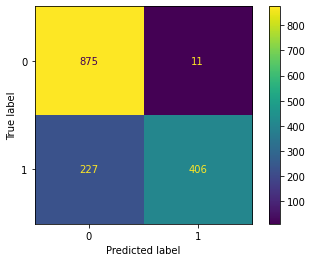

In [15]:
plot_confusion_matrix(forest, X_test, y_test)

## Tree number influence

In [16]:
def accuracy_if_use_n_trees(n, y_test):
    forest = Forest(trees_number=n, tree_factory=DecisionTreeClassifier)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    return accuracy_score(y_test, y_pred)

def run_forest(n, y_test):
    clf = RandomForestClassifier(n_estimators=n, max_depth=2, random_state=0)
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

trees_number = [2, 10, 50, 100]
my_accuracies = [accuracy_if_use_n_trees(n, y_test) for n in trees_number]
accuracies = [run_forest(n, y_test) for n in trees_number]

tree_df = pd.DataFrame({'tree number': trees_number, 'my forest acc': my_accuracies, 'scikit forest acc':accuracies})
tree_df

tree number  my forest acc  scikit forest acc
0            2       0.721527           0.782752
1           10       0.832785           0.876893
2           50       0.847268           0.885451
3          100       0.864384           0.885451

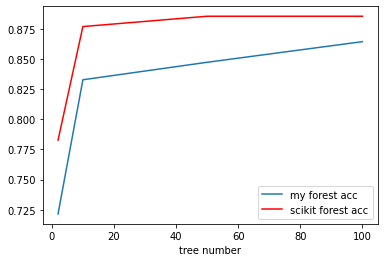

In [17]:
ax = plt.gca()

tree_df.plot(kind='line',x='tree number',y='my forest acc',ax=ax)
tree_df.plot(kind='line',x='tree number',y='scikit forest acc', color='red', ax=ax)

plt.show()

# Results and discussion

In this task we had a dataset with 57 features and we needed to classify emails into the spam and not spam categories based on these features. 

We implemented the random forest algorithm which included the dataset bootstrapping and random feature selection for 
an individual tree. After that we plotted its confusion matrix and compared with RandomForestClassifier from the scikitlearn library in terms of the accuracy criteria. 

The comparison included changing the number of trees in both forests. We can observe the trend that the more classifiers we have the better prediction we get. It correspond with the theoretical prediction. Nonetheless, a big number of predictors increases computation time as well as the probability of growing correlated trees 

![alt text](data/Vote_correctness_probobilty.png "Title")
